<a href="https://colab.research.google.com/github/sagargohel95/CE888-7-sp/blob/main/Lab_3_bank_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, plot_confusion_matrix, SCORERS
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [ ]:
df_raw = pd.read_csv('https://github.com/albanda/CE888/raw/master/lab3/bank-additional-full.csv', delimiter = ';')
df = df_raw.drop(['duration'], axis=1)

In [ ]:
#check for empty rows
print("Number of rows before dropping NaNs: %d" % len(df))
df = df.dropna()
print("Number of rows after dropping NaNs: %d" % len(df))

Number of rows before dropping NaNs: 41188
Number of rows after dropping NaNs: 41188


In [ ]:
features = [col for col in df.columns[:-1]] # each column except the last one
outcomes_of_interest = ['y']
cat_features = [col for col in df.columns[1:10]] + ['poutcome']

In [ ]:
df[outcomes_of_interest] = df[outcomes_of_interest].apply(LabelEncoder().fit_transform)

In [ ]:
X_df = df[features].copy()
y_df = df[outcomes_of_interest].copy()
X_df = pd.get_dummies(X_df, columns=cat_features)

<AxesSubplot:xlabel='y'>

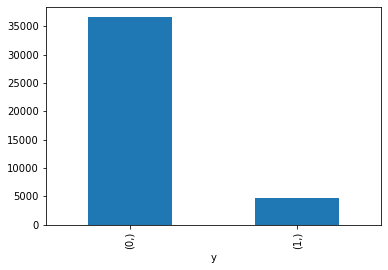

In [ ]:
X = X_df.values
y = y_df.values.T[0]

y_df.value_counts().plot(kind='bar')

In [ ]:
def imbalanceratio(negative, positive):
    return negative/positive

In [ ]:
imbalanceratio(y_df.value_counts()[1], y_df.value_counts()[0])

0.126956331399803

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=50, stratify=y)
X_train.shape, X_test.shape

((32950, 62), (8238, 62))

In [ ]:
y_train.shape, y_test.shape

((32950,), (8238,))

In [ ]:
dummy_clf = DummyClassifier(strategy='stratified')
dummy_clf.fit(X_train, y_train)
print("Dummy F1 Score: %.2f" % f1_score(y_test, dummy_clf.predict(X_test)))

Dummy F1 Score: 0.10


In [ ]:
SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'top_k_accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_wei

In [ ]:
def cvscore(estimator, depth, state=50, folds=10):
    cv = cross_val_score(RandomForestClassifier(n_estimators=estimator, max_depth=depth, random_state=state), X_train, y_train, cv=folds, scoring='f1')
    print(("F1 Score: %.2f" % (cv.mean())))

In [ ]:
cvscore(100, 3)

F1 Score: 0.26


In [ ]:
# Create the parameter grid
param_grid = {
     'n_estimators': [50, 75],
     'max_depth': [3, None],
     'min_samples_split': [2, 3],
     'min_samples_leaf': [1, 2],
     'max_features': [3, 'auto'],
}
# Create a base model
rf = RandomForestClassifier(random_state=50, class_weight='balanced')
# Instantiate the grid search model
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=10, scoring='f1', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

Fitting 10 folds for each of 32 candidates, totalling 320 fits


GridSearchCV(cv=10,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=50),
             n_jobs=-1,
             param_grid={'max_depth': [3, None], 'max_features': [3, 'auto'],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 3],
                         'n_estimators': [50, 75]},
             scoring='f1', verbose=2)

In [ ]:
grid_search.best_params_

{'max_depth': None,
 'max_features': 3,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 75}

In [ ]:
df_results = pd.DataFrame(grid_search.cv_results_)

In [ ]:
grid_search.best_score_

0.4958800337866209

In [ ]:
print("F1 Score: %.2f" % f1_score(y_test, grid_search.predict(X_test)))

F1 Score: 0.50


In [ ]:
def top_x_features(x):
    for i in range(x):
        print(X_df.columns[[sorted(importance_sorted, reverse=True)[i][1]]])

In [ ]:
def genenralizationerror(classifier):
    y_bias = (np.nanmean(y_test) - np.nanmean(classifier.predict(X_test), axis=0)) **2
    y_error = np.nanmean((y_test - classifier.predict(X_test)) **2, axis=0)#.mean()
    y_var = np.nanvar(classifier.predict(X_test), axis=0, ddof = 1)
    print(np.nanmean(y_bias) +  np.nanmean(y_var))
    clf_type = "Decision tree"
    print("{0}: {1:.4f} (error) = {2:.4f} (bias^2) "
              "+ {3:.4f} (var)".format(clf_type, np.nanmean(y_error), np.nanmean(y_bias), np.nanmean(y_var)))
    print("{0}: {1:.4f} ((bias^2) + (var)) = {2:.4f} (bias^2) "
              "+ {3:.4f} (var)".format(clf_type, np.mean(y_bias) + np.mean(y_var), np.mean(y_bias), np.mean(y_var)))

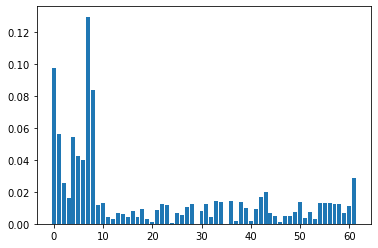

[(0.12935660738023427, 7),
 (0.09736903913329371, 0),
 (0.08367458465625469, 8),
 (0.05596354369376038, 1),
 (0.054203470829942764, 4),
 (0.042424303483114836, 5),
 (0.04006606725235576, 6),
 (0.028754974412186815, 61),
 (0.025449807601838837, 2),
 (0.019878059523950282, 43),
 (0.016548796292443834, 42),
 (0.01626970093065214, 3),
 (0.014504607785969556, 33),
 (0.01431381488376839, 36),
 (0.013867009413885509, 50),
 (0.013804614718561562, 38),
 (0.013674160633336766, 34),
 (0.013294985486140217, 56),
 (0.013168325756097816, 54),
 (0.012844342215803614, 10),
 (0.012740424223737378, 55),
 (0.01255871079351913, 28),
 (0.012493561853211443, 31),
 (0.012489975686165352, 57),
 (0.012444601440831428, 58),
 (0.012384000889944116, 22),
 (0.01194337212204152, 23),
 (0.011698024640020345, 9),
 (0.011197226658223897, 60),
 (0.010709153506137598, 27),
 (0.009981632157703117, 39),
 (0.00944987269855821, 18),
 (0.009408928217323498, 41),
 (0.008393793422670397, 21),
 (0.008240944012789572, 16),
 (0.0

In [ ]:
importance = grid_search.best_estimator_.feature_importances_
importance_sorted = []
for i,v in enumerate(importance):
    importance_sorted.append((v,i))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()
sorted(importance_sorted, reverse=True)

In [ ]:
top_x_features(3)

Index(['euribor3m'], dtype='object')
Index(['age'], dtype='object')
Index(['nr.employed'], dtype='object')


In [ ]:
genenralizationerror(grid_search)

0.12254337502065248
Decision tree: 0.1277 (error) = 0.0008 (bias^2) + 0.1217 (var)
Decision tree: 0.1225 ((bias^2) + (var)) = 0.0008 (bias^2) + 0.1217 (var)


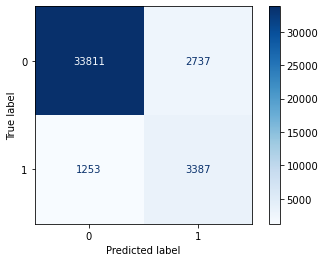

In [ ]:
plot_confusion_matrix(grid_search, X, y, cmap=plt.cm.Blues)
plt.show()

## Quiz

In [ ]:
def RFQuiz(n_estimators, max_depth, random_state):
    RF = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=random_state)
    RF.fit(X_train, y_train)
    RF.predict(X_test)
    print("F1 Score: %.2f" % f1_score(y_test, RF.predict(X_test)))
    return RF

In [ ]:
cvscore(300, 6)

F1 Score: 0.28


In [ ]:
cvscore(250, 6)

F1 Score: 0.28


In [ ]:
RFQuiz(1000, 8, 60)

F1 Score: 0.33


RandomForestClassifier(max_depth=8, n_estimators=1000, random_state=60)

F1 Score: 0.37


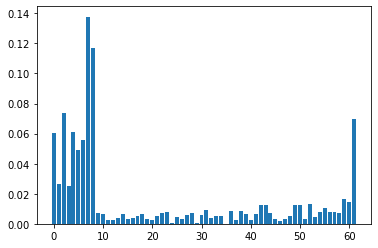

[(0.1377797819953523, 7),
 (0.11692728722385545, 8),
 (0.07401743620618534, 2),
 (0.06978387385403358, 61),
 (0.06136299013262599, 4),
 (0.06016619676183461, 0),
 (0.05554340279758939, 6),
 (0.04897915171607266, 5),
 (0.02630804436668193, 1),
 (0.025350875715854836, 3),
 (0.016381711117331506, 59),
 (0.014781772023583965, 60),
 (0.013437985880937723, 52),
 (0.012811341176162191, 49),
 (0.012810392740654269, 43),
 (0.01235650801647128, 50),
 (0.012290151011588797, 42),
 (0.01037130140043358, 55),
 (0.009046646865404795, 31),
 (0.008521076030657453, 38),
 (0.008431097982839883, 36),
 (0.008163850193999542, 56),
 (0.007796162028052489, 54),
 (0.007610582791731387, 23),
 (0.007522588966208642, 57),
 (0.007449667159404616, 22),
 (0.0074373927700695334, 44),
 (0.0072479004735506065, 28),
 (0.007053950652373452, 58),
 (0.006952476394268106, 9),
 (0.006846941259566019, 39),
 (0.006599864709721944, 10),
 (0.0062503262715499375, 14),
 (0.006243569755776649, 41),
 (0.006189616558043596, 18),
 (0.

In [ ]:
importance = RFQuiz(300, 12, 60).feature_importances_
importance_sorted = []
for i,v in enumerate(importance):
    importance_sorted.append((v,i))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()
sorted(importance_sorted, reverse=True)

In [ ]:
top_x_features(3)

Index(['euribor3m'], dtype='object')
Index(['nr.employed'], dtype='object')
Index(['pdays'], dtype='object')
